<a href="https://colab.research.google.com/github/Se1towo/IMLO_Exam/blob/main/IMLO_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [89]:
# Download full dataset
flowers_102 = torchvision.datasets.Flowers102(
    root="data",
    download=True,
    transform=ToTensor())

In [125]:
# Get dimensions of largest image
max_width = 0
max_height = 0

for i in range(len(flowers_102)):
    img, label = flowers_102[i]
    _, width, height = img.size()  # Get the dimensions of the image
    max_width = max(max_width, width)
    max_height = max(max_height, height)

In [139]:
# Pads all images to be uniform (dimensions of largest image)
transform = transforms.Compose([
    #transforms.Pad(padding=((max_width - width)//2, (max_height - height)//2)),
    transforms.Resize((max_width, max_height)),
    transforms.ToTensor()
])
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

# Split the dataset into test and train datasets
training_data = torchvision.datasets.Flowers102(
    root="data",
    split = "train",
    download=True,
    transform=transform)

test_data = torchvision.datasets.Flowers102(
    root="data",
    split = "test",
    download=True,
    transform=transform)

#Updated image sizes
print(max_width)
print(max_height)

993
919


In [140]:
# # Split the dataset into test and train datasets
# training_data = torchvision.datasets.Flowers102(
#     root="data",
#     split = "train",
#     download=True,
#     transform=ToTensor())

# test_data = torchvision.datasets.Flowers102(
#     root="data",
#     split = "test",
#     download=True,
#     transform=ToTensor())

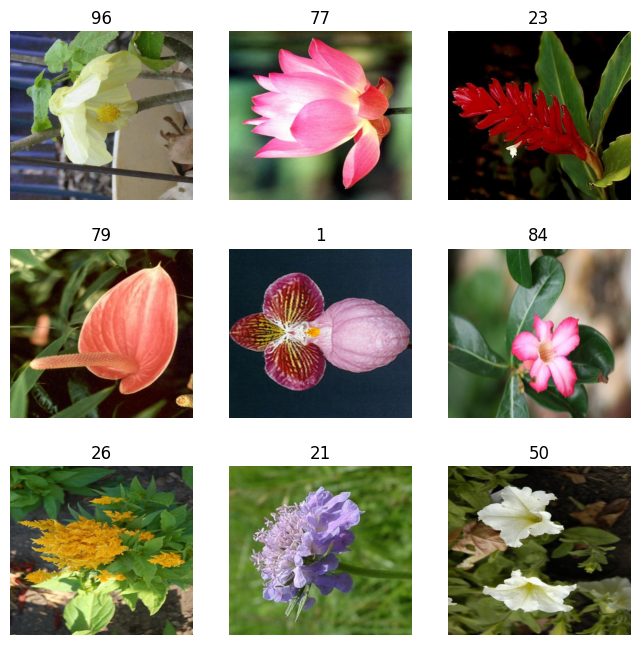

In [141]:
labels_map = {}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    if label not in labels_map:
      labels_map[label] = img
    figure.add_subplot(rows, cols, i)
    plt.title(list(labels_map.keys())[i-1]) #crashes for some runs but works on rerun
    plt.axis("off")
    plt.imshow(img.squeeze().T)
plt.show()

In [143]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(max_width*max_height, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [144]:
# Try to train model on hardware accelerator
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [145]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=912567, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [146]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 993, 919])
Labels batch shape: torch.Size([64])


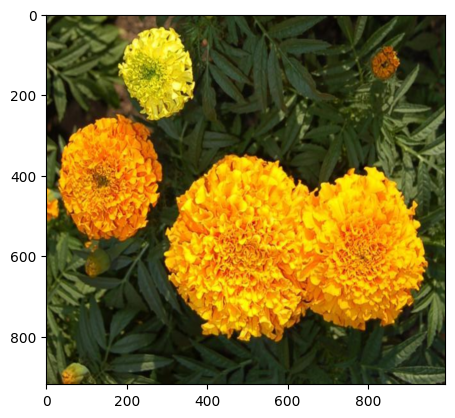

Label: 46


In [147]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T)
plt.show()
print(f"Label: {label}")

In [159]:
# Try to set up singular example prediction
X = torch.rand(1, max_width, max_height, device=device) #change from 28 by 28?
print(X.size())
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

torch.Size([1, 993, 919])
Predicted class: tensor([4])


In [151]:
# Take minibatch to test layers
input_image = torch.rand(3, max_width, max_height)
print(input_image.size())

# Convert each iamge to a continguous array of pixel values
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

# Apply lienar transformation
layer1 = nn.Linear(in_features=max_width*max_height, out_features=64)
hidden1 = layer1(flat_image)
print(hidden1.size())

#Introduce nonlinearity
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

#Pass data sequentially
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(64, 10)
)
input_image = torch.rand(3,max_width*max_height)
logits = seq_modules(input_image)

#Rescale outputs to sum to 1
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)
print("softmax:", softmax)
print("pred_probab:", pred_probab)

torch.Size([3, 993, 919])
torch.Size([3, 912567])
torch.Size([3, 64])
Before ReLU: tensor([[-0.2521,  0.1228,  0.1833, -0.6296, -0.3639, -0.2142, -0.4308,  0.1761,
         -0.3988,  0.3482,  0.0471, -0.1167, -0.1979, -0.4291,  0.1268, -0.0128,
         -0.0996, -0.1363, -0.1672, -0.0385, -0.0435,  0.5616, -0.3809,  0.3296,
         -0.1717, -0.7990,  0.2108, -0.4484, -0.3407, -0.0789,  0.0619, -0.2108,
          0.0336, -0.1218, -0.3486,  0.2759, -0.0833, -0.2221,  0.6460,  0.0351,
         -0.5406,  0.1626,  0.2185,  0.2474, -0.0240,  0.2267,  0.2759,  0.2454,
          0.1606,  0.1838,  0.4192,  0.0764,  0.4802,  0.7199,  0.0410, -0.0129,
          0.4782,  0.2615, -0.0210,  0.0601,  0.2841,  0.1406, -0.3280, -0.0329],
        [-0.6258, -0.5040,  0.1107, -0.5059, -0.1396, -0.6916, -0.0162, -0.1452,
         -0.6659,  0.3090,  0.1373,  0.0158, -0.1814, -0.1960,  0.3579,  0.0496,
         -0.0273, -0.0974, -0.2549,  0.2207,  0.1062,  0.5208, -0.0145,  0.1309,
         -0.0486, -0.7656

In [160]:
# Iterate over each parameter, and print its size and a preview of its value
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=912567, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([64, 912567]) | Values : tensor([[-0.0005, -0.0008, -0.0007,  ...,  0.0003, -0.0005, -0.0009],
        [ 0.0006, -0.0002, -0.0006,  ..., -0.0008, -0.0009,  0.0005]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([64]) | Values : tensor([-0.0004, -0.0010], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([64, 64]) | Values : tensor([[-0.0589, -0.0371,  0.0495,  0.0381,  0.0968, -0.0971,  0.0774,  0.0756,
         -0.0289,  0.0615, -0.0019,  0.0646,  0.0580, -0.0902,  0.0732, -0.0265,
         -0.0791,  0.0039, -0.0065,  0.1098, -0.06

In [153]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [154]:
# Establishing Loss function and Optimiser
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [155]:
# Compute gradient of loss function with respect to given parameter for simplest one-layer neural network
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [156]:
# Backward propogation
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7802633ae8c0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7802633ad690>


In [157]:
# Optimize weights of parameters in the neural network,by computing the derivatives of our loss function with respect to parameters
# Compute gradients
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0059, 0.0790, 0.0682],
        [0.0059, 0.0790, 0.0682],
        [0.0059, 0.0790, 0.0682],
        [0.0059, 0.0790, 0.0682],
        [0.0059, 0.0790, 0.0682]])
tensor([0.0059, 0.0790, 0.0682])


In [164]:
batch, (X, y) = enumerate(train_dataloader)
print(batch)
print(X)
print(y)

ValueError: too many values to unpack (expected 2)

In [161]:
for batch, (X, y) in enumerate(train_dataloader):
      X, y = X.to(device), y.to(device)
      print("X:", X.type())
      print("X:", X.size())
      print("y:", y.size())

      # Compute prediction and loss
      pred = model(X)
      loss = loss_fn(pred, y)

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      if batch % 100 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

0
X: torch.FloatTensor
X: torch.Size([64, 3, 993, 919])
y: torch.Size([64])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2737701 and 912567x64)

In [165]:
# Training the model
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [166]:
# Check the accuracy of the model against the actual labels in the dataset
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [167]:
# Initialize the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [168]:
# Repeat the accuracy test over mulitple epochs to increase the accuracy of predictions
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2737701 and 912567x64)

In [ ]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

In [ ]:
# Visualise a sample of the data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
# Save the model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")